In [3]:
import os
import pandas as pd
import numpy as np

# Base path to your dataset
base_path = os.path.join("data", "UCI")

# STEP 1: Load and clean feature names
features = pd.read_csv(
    os.path.join(base_path, "features.txt"),
    sep="\s+", header=None, names=["index", "feature_name"]
)

# Force unique column names by appending an index if duplicate exists
from collections import defaultdict

feature_count = defaultdict(int)
unique_feature_names = []

for name in features["feature_name"]:
    name = name.strip()
    feature_count[name] += 1
    if feature_count[name] == 1:
        unique_feature_names.append(name)
    else:
        unique_feature_names.append(f"{name}_{feature_count[name]}")

# STEP 2: Load activity labels
activity_labels = pd.read_csv(
    os.path.join(base_path, "activity_labels.txt"),
    sep="\s+", header=None, names=["id", "activity"]
)
activity_map = dict(zip(activity_labels["id"], activity_labels["activity"]))

# STEP 3: Load training data
X_train = pd.read_csv(
    os.path.join(base_path, "train", "X_train.txt"),
    sep="\s+", header=None, names=unique_feature_names
)

y_train = pd.read_csv(
    os.path.join(base_path, "train", "y_train.txt"),
    header=None, names=["Activity"]
)

subject_train = pd.read_csv(
    os.path.join(base_path, "train", "subject_train.txt"),
    header=None, names=["Subject"]
)

# STEP 4: Combine into one DataFrame
train_df = pd.concat([subject_train, y_train, X_train], axis=1)
train_df["ActivityName"] = train_df["Activity"].map(activity_map)

# STEP 5: Preview
print("✅ Data imported successfully!")
print("📐 Shape of training data:", train_df.shape)
print("🎯 Sample activity labels:", train_df['ActivityName'].unique())
print("👥 Unique subjects:", train_df['Subject'].nunique())
train_df.head()


✅ Data imported successfully!
📐 Shape of training data: (7352, 564)
🎯 Sample activity labels: ['STANDING' 'SITTING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']
👥 Unique subjects: 21


,Subject,Activity,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",ActivityName
0,1,5,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,1,5,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,1,5,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,1,5,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,1,5,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


🔁 Highly correlated features (>0.95): 308
📉 Low variance features (<0.01): 37


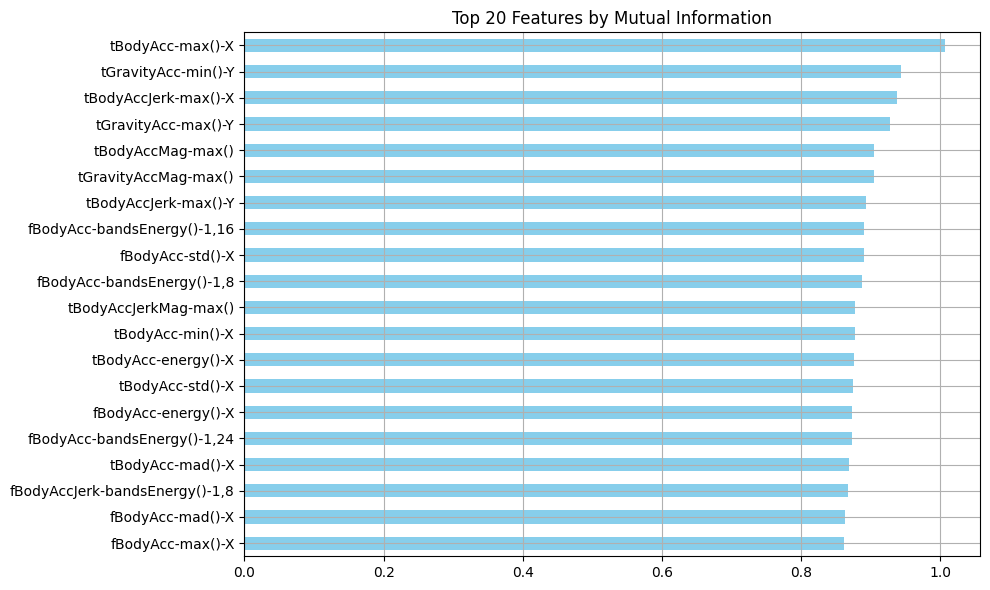

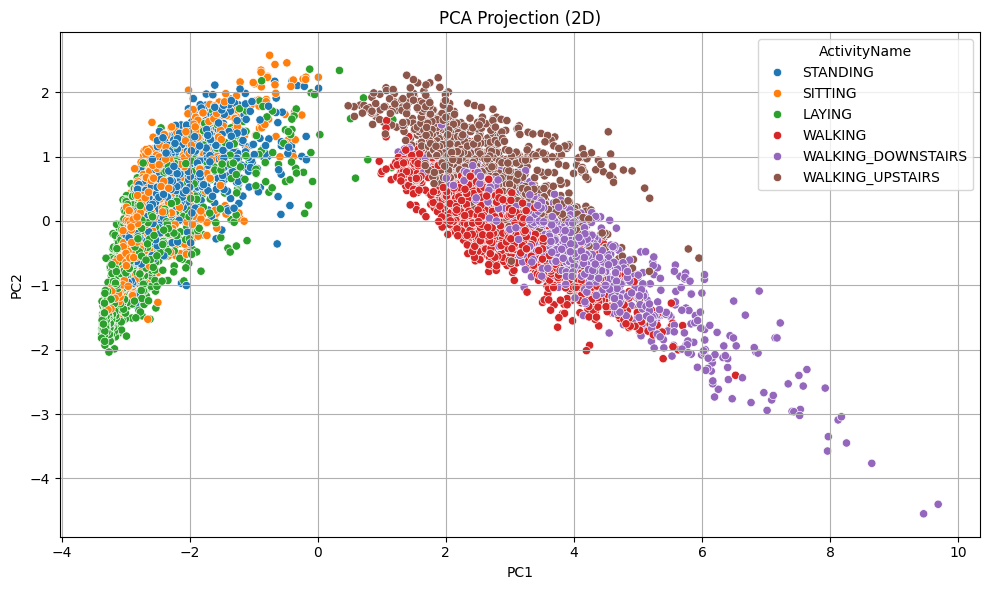

In [4]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 6: Prepare X and y
X = train_df.drop(columns=["Subject", "Activity", "ActivityName"])
y = train_df["Activity"]

# STEP 7: Correlation Matrix (remove highly correlated features > 0.95)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [col for col in upper.columns if any(upper[col] > 0.95)]
print(f"🔁 Highly correlated features (>0.95): {len(high_corr_features)}")

# STEP 8: Variance Threshold (remove low variance features)
var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(X)
low_variance_features = X.columns[~var_thresh.get_support()]
print(f"📉 Low variance features (<0.01): {len(low_variance_features)}")

# STEP 9: Mutual Information Feature Selection
mi_selector = SelectKBest(mutual_info_classif, k=20)
mi_selector.fit(X, y)
mi_scores = pd.Series(mi_selector.scores_, index=X.columns).sort_values(ascending=False)

# Visualize top 20 mutual information scores
plt.figure(figsize=(10, 6))
mi_scores.head(20).plot(kind='barh', color='skyblue')
plt.title("Top 20 Features by Mutual Information")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 10: PCA for Dimensionality Reduction
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["ActivityName"] = train_df["ActivityName"]

# Visualize PCA result
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="ActivityName", palette="tab10")
plt.title("PCA Projection (2D)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

# STEP 1: Drop highly correlated features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [col for col in upper.columns if any(upper[col] > 0.95)]

# STEP 2: Drop low variance features
var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(X)
low_variance_features = X.columns[~var_thresh.get_support()]

# STEP 3: Combine dropped features
features_to_drop = list(set(high_corr_features).union(set(low_variance_features)))
X_cleaned = X.drop(columns=features_to_drop)

# STEP 4: Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_cleaned)
X_normalized_df = pd.DataFrame(X_normalized, columns=X_cleaned.columns)

# STEP 5: Encode labels (for classification)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_df["Activity"])

# STEP 6: Build final DataFrame
prepared_df = pd.concat([
    train_df[["Subject"]].reset_index(drop=True),
    pd.DataFrame({"Activity": y_encoded}),
    X_normalized_df
], axis=1)

# Optional: map activity names back in a readable column
prepared_df["ActivityName"] = label_encoder.inverse_transform(y_encoded)

# ✅ Preview
print("📦 Prepared data sample:")
display(prepared_df.head(20))  # works best in Jupyter


📦 Prepared data sample:


,Subject,Activity,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-max()-Z,tBodyAcc-min()-Z,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-entropy()-X,...,fBodyBodyGyroMag-skewness(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)",ActivityName
0,1,4,-0.868814,-0.939441,-0.737529,-0.637379,0.738383,-0.775696,-0.670496,-0.649898,...,2.571343,-0.616153,-0.706661,-0.795359,0.025960,-0.360603,0.062940,-0.778427,-0.026080,5
1,1,4,-0.875426,-0.923902,-0.849304,-0.889197,0.766503,-0.775105,-0.687585,-1.304893,...,-0.253097,-0.633698,-0.706661,0.130614,-0.897357,0.133011,-0.021461,-1.218805,1.484470,5
2,1,4,-0.869039,-0.907760,-0.893785,-0.889197,0.822606,-0.774088,-0.692379,-1.043324,...,-0.862529,-0.641077,2.398628,1.152336,-0.260878,-0.377840,0.391976,0.151207,1.704201,5
3,1,4,-0.870626,-0.940022,-0.921805,-0.927662,0.817653,-0.774691,-0.692533,-1.118413,...,0.072130,-0.640381,-0.263048,1.112769,0.591045,-0.135025,-0.033637,1.037851,-1.003019,5
4,1,4,-0.875188,-0.934878,-0.921343,-0.910626,0.817653,-0.775640,-0.693672,-1.457712,...,-0.785768,-0.649103,-0.263048,-0.149577,-0.138515,0.340406,0.268486,1.125918,-1.276282,5
5,1,4,-0.873397,-0.954117,-0.933139,-0.904026,0.844693,-0.775649,-0.694396,-1.383748,...,-0.282901,-0.654800,-0.706661,-0.419721,-0.742707,0.219586,-0.324856,0.437830,-0.757922,5
6,1,4,-0.872474,-0.907757,-0.903754,-0.885047,0.803288,-0.774076,-0.693119,-1.139181,...,-0.208028,-0.646600,-0.706661,0.081880,0.279795,-0.657546,-0.519341,0.009718,-0.384001,5
7,1,4,-0.871668,-0.906847,-0.900094,-0.885047,0.799231,-0.771564,-0.691001,-1.130767,...,-0.470407,-0.646974,-0.706661,0.044181,0.700031,-0.087811,1.320191,-0.938078,0.990421,5
8,1,4,-0.873382,-0.895938,-0.905077,-0.906615,0.799231,-0.773043,-0.692183,-1.237133,...,-0.360501,-0.629394,-0.706661,0.752040,0.117163,0.012681,0.175674,-0.399562,0.258981,5
9,1,4,-0.867755,-0.918844,-0.911221,-0.880491,0.819621,-0.774103,-0.693498,-0.954795,...,1.103588,-0.584233,-0.706661,0.566145,2.014197,-0.086925,-0.289813,-0.808199,-0.135349,5


0        1
1        1
2        1
3        1
4        1
        ..
7347    30
7348    30
7349    30
7350    30
7351    30
Name: Subject, Length: 7352, dtype: int64
kkkkkkk
0       4
1       4
2       4
3       4
4       4
       ..
7347    1
7348    1
7349    1
7350    1
7351    1
Name: Activity, Length: 7352, dtype: int64
yooooooooooo
      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-max()-Z  \
0            -0.868814         -0.939441         -0.737529         -0.637379   
1            -0.875426         -0.923902         -0.849304         -0.889197   
2            -0.869039         -0.907760         -0.893785         -0.889197   
3            -0.870626         -0.940022         -0.921805         -0.927662   
4            -0.875188         -0.934878         -0.921343         -0.910626   
...                ...               ...               ...               ...   
7347          0.913859          1.095963          1.628612          1.634933   
7348          0.824887 

/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 2 (Subject 3):
  Accuracy           = 0.9707 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0885 -> Lower loss indicates more reliable probability estimates.

Fold 3 (Subject 5):
  Accuracy           = 0.8907 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.5014 -> Lower loss indicates more reliable probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 4 (Subject 6):
  Accuracy           = 0.8708 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.6155 -> Lower loss indicates more reliable probability estimates.

Fold 5 (Subject 7):
  Accuracy           = 0.8734 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.4403 -> Lower loss indicates more reliable probability estimates.

Fold 6 (Subject 8):
  Accuracy           = 0.9680 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0765 -> Lower loss indicates more reliable probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 7 (Subject 11):
  Accuracy           = 0.9842 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0478 -> Lower loss indicates more reliable probability estimates.

Fold 8 (Subject 14):
  Accuracy           = 0.7152 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 1.8406 -> Lower loss indicates more reliable probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/aura1/lib/python3.9

Fold 9 (Subject 15):
  Accuracy           = 0.9878 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0560 -> Lower loss indicates more reliable probability estimates.

Fold 10 (Subject 16):
  Accuracy           = 0.7760 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.8153 -> Lower loss indicates more reliable probability estimates.

Fold 11 (Subject 17):
  Accuracy           = 0.9783 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0562 -> Lower loss indicates more reliable probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 12 (Subject 19):
  Accuracy           = 0.9194 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.1930 -> Lower loss indicates more reliable probability estimates.

Fold 13 (Subject 21):
  Accuracy           = 0.9363 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.2074 -> Lower loss indicates more reliable probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 14 (Subject 22):
  Accuracy           = 0.9720 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0649 -> Lower loss indicates more reliable probability estimates.

Fold 15 (Subject 23):
  Accuracy           = 0.9812 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0585 -> Lower loss indicates more reliable probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 16 (Subject 25):
  Accuracy           = 0.9462 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.1648 -> Lower loss indicates more reliable probability estimates.

Fold 17 (Subject 26):
  Accuracy           = 0.9719 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0724 -> Lower loss indicates more reliable probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 18 (Subject 27):
  Accuracy           = 0.9894 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0343 -> Lower loss indicates more reliable probability estimates.

Fold 19 (Subject 28):
  Accuracy           = 0.9031 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.3709 -> Lower loss indicates more reliable probability estimates.

Fold 20 (Subject 29):
  Accuracy           = 0.9593 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.1176 -> Lower loss indicates more reliable probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 21 (Subject 30):
  Accuracy           = 0.9843 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0374 -> Lower loss indicates more reliable probability estimates.

Overall LOSO-CV Results (Logistic Regression):


,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.991354,0.018495
1,2,3,0.970674,0.088537
2,3,5,0.890728,0.501391
3,4,6,0.870769,0.615488
4,5,7,0.873377,0.440295
5,6,8,0.967972,0.076522
6,7,11,0.984177,0.047762
7,8,14,0.715170,1.840626
8,9,15,0.987805,0.056035
9,10,16,0.775956,0.815281



Average Accuracy: 0.9319
Average Cross-Entropy Loss: 0.2799


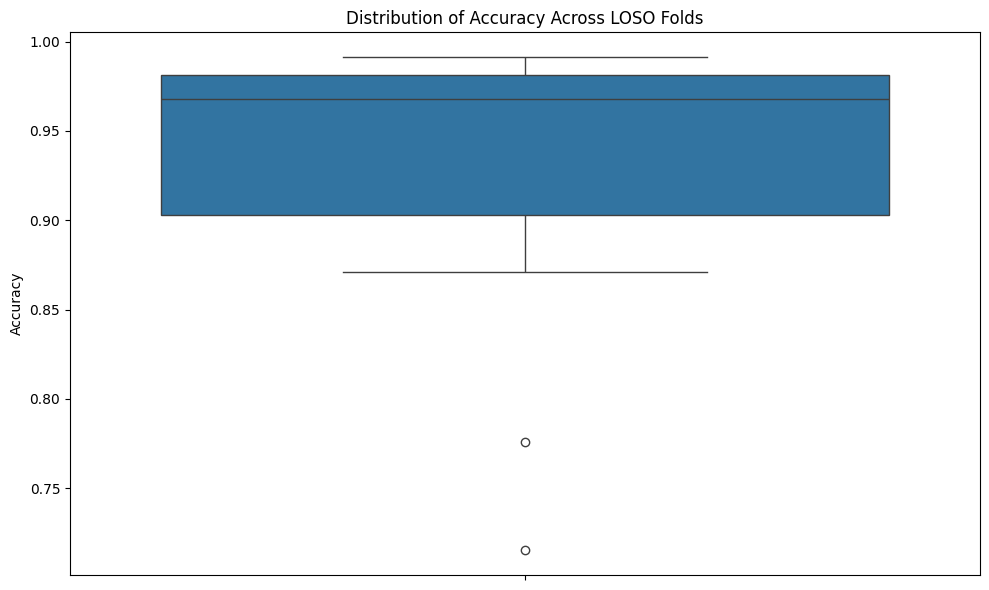


Testing on 3 Random Samples:
Sample 1 (Index 1562):
  True Activity     : 1
  Predicted Activity: 1
----------------------------------------
Sample 2 (Index 3228):
  True Activity     : 2
  Predicted Activity: 2
----------------------------------------
Sample 3 (Index 6502):
  True Activity     : 4
  Predicted Activity: 4
----------------------------------------


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [6]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# BLO4: LOSO-CV Training & Evaluation for Logistic Regression
# ==========================================

# STEP 1: Extract data from prepared_df
X_full = prepared_df.drop(columns=["Subject", "Activity", "ActivityName"])
y_full = prepared_df["Activity"]
groups = prepared_df["Subject"]
print(groups)
print("kkkkkkk")
print(y_full)
print("yooooooooooo")
print(X_full)

# STEP 2: Set up Leave-One-Subject-Out CV
logo = LeaveOneGroupOut()

# Containers to store metrics for each fold
fold_accuracies = []
fold_losses = []
fold_reports = []
fold_subjects = []  # to record which subject is held out

print("Starting Leave-One-Subject-Out Cross-Validation (LOSO-CV):\n")

# STEP 3: Iterate over each subject (fold)
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    # Get held-out subject ID (all entries in test_idx have the same Subject)
    test_subject = groups.iloc[test_idx].unique()[0]
    fold_subjects.append(test_subject)
    
    # Split data for this fold
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    # Train Logistic Regression (multinomial uses cross-entropy loss)
    model = LogisticRegression(max_iter=300, multi_class='multinomial', solver='lbfgs', random_state=42)
    model.fit(X_train_fold, y_train_fold)
    
    # Predict on the held-out subject's data
    y_pred = model.predict(X_test_fold)
    y_proba = model.predict_proba(X_test_fold)
    
    # Calculate metrics for this fold
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    report = classification_report(y_test_fold, y_pred, output_dict=True)
    
    fold_accuracies.append(acc)
    fold_losses.append(ce_loss)
    fold_reports.append(report)
    
    # Print per-fold results with explanation
    print(f"Fold {fold+1} (Subject {test_subject}):")
    print(f"  Accuracy           = {acc:.4f} -> Percentage of correct predictions for this subject.")
    print(f"  Cross-Entropy Loss = {ce_loss:.4f} -> Lower loss indicates more reliable probability estimates.\n")

# STEP 4: Summarize LOSO results in a DataFrame
results_df = pd.DataFrame({
    "Fold": list(range(1, len(fold_accuracies)+1)),
    "Subject": fold_subjects,
    "Accuracy": fold_accuracies,
    "CrossEntropyLoss": fold_losses
})
print("Overall LOSO-CV Results (Logistic Regression):")
display(results_df)
print("\nAverage Accuracy: {:.4f}".format(np.mean(fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(fold_losses)))

# Plot distribution of accuracies across folds
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, y="Accuracy")
plt.title("Distribution of Accuracy Across LOSO Folds")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# ==========================================
# BLO4 - Part 2: Additional Testing on Random Samples
# ==========================================
# Now, to check predictions on unseen testing samples:
# Train a final model on the entire prepared data.
final_model = LogisticRegression(max_iter=300, multi_class='multinomial', solver='lbfgs', random_state=42)
final_model.fit(X_full, y_full)

# Randomly select 3 samples from the entire dataset (for demonstration)
random_indices = np.random.choice(X_full.index, size=3, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]

# Generate predictions for these samples
predicted_labels = final_model.predict(test_samples)

# Convert numeric labels to activity names using the label encoder
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)

# Print predicted vs. true activities for each sample
print("\nTesting on 3 Random Samples:")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}):")
    print(f"  True Activity     : {true_activities[i]}")
    print(f"  Predicted Activity: {predicted_activities[i]}")
    print("-" * 40)


Starting LOSO-CV for Random Forest:

Fold 1 (Subject 1):
  Accuracy           = 0.9625 -> Indicates the percentage of correct predictions for the test subject.
  Cross-Entropy Loss = 0.2448 -> Lower loss shows better-calibrated probability estimates.

Fold 2 (Subject 3):
  Accuracy           = 0.9853 -> Indicates the percentage of correct predictions for the test subject.
  Cross-Entropy Loss = 0.2560 -> Lower loss shows better-calibrated probability estimates.

Fold 3 (Subject 5):
  Accuracy           = 0.8146 -> Indicates the percentage of correct predictions for the test subject.
  Cross-Entropy Loss = 0.4459 -> Lower loss shows better-calibrated probability estimates.

Fold 4 (Subject 6):
  Accuracy           = 0.8615 -> Indicates the percentage of correct predictions for the test subject.
  Cross-Entropy Loss = 0.3928 -> Lower loss shows better-calibrated probability estimates.

Fold 5 (Subject 7):
  Accuracy           = 0.9448 -> Indicates the percentage of correct predictions fo

/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 8 (Subject 14):
  Accuracy           = 0.7461 -> Indicates the percentage of correct predictions for the test subject.
  Cross-Entropy Loss = 0.5826 -> Lower loss shows better-calibrated probability estimates.

Fold 9 (Subject 15):
  Accuracy           = 1.0000 -> Indicates the percentage of correct predictions for the test subject.
  Cross-Entropy Loss = 0.2346 -> Lower loss shows better-calibrated probability estimates.

Fold 10 (Subject 16):
  Accuracy           = 0.8361 -> Indicates the percentage of correct predictions for the test subject.
  Cross-Entropy Loss = 0.4364 -> Lower loss shows better-calibrated probability estimates.

Fold 11 (Subject 17):
  Accuracy           = 0.9565 -> Indicates the percentage of correct predictions for the test subject.
  Cross-Entropy Loss = 0.2604 -> Lower loss shows better-calibrated probability estimates.

Fold 12 (Subject 19):
  Accuracy           = 0.8667 -> Indicates the percentage of correct predictions for the test subject.
  Cross-E

,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.962536,0.244766
1,2,3,0.985337,0.255996
2,3,5,0.814570,0.445888
3,4,6,0.861538,0.392776
4,5,7,0.944805,0.334169
5,6,8,0.946619,0.322457
6,7,11,0.984177,0.245595
7,8,14,0.746130,0.582615
8,9,15,1.000000,0.234551
9,10,16,0.836066,0.436363



Average Accuracy: 0.9176
Average Cross-Entropy Loss: 0.3187


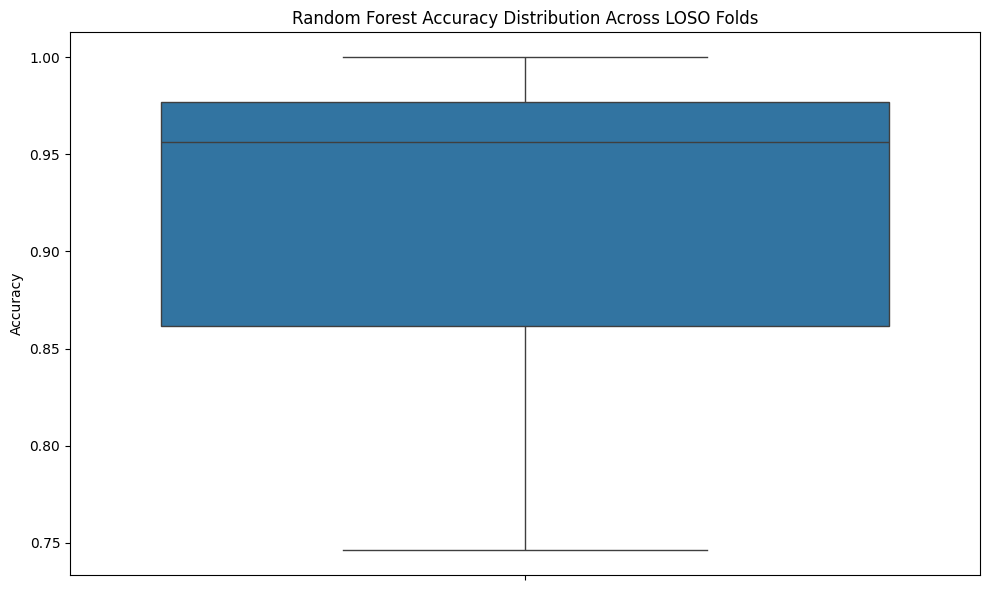

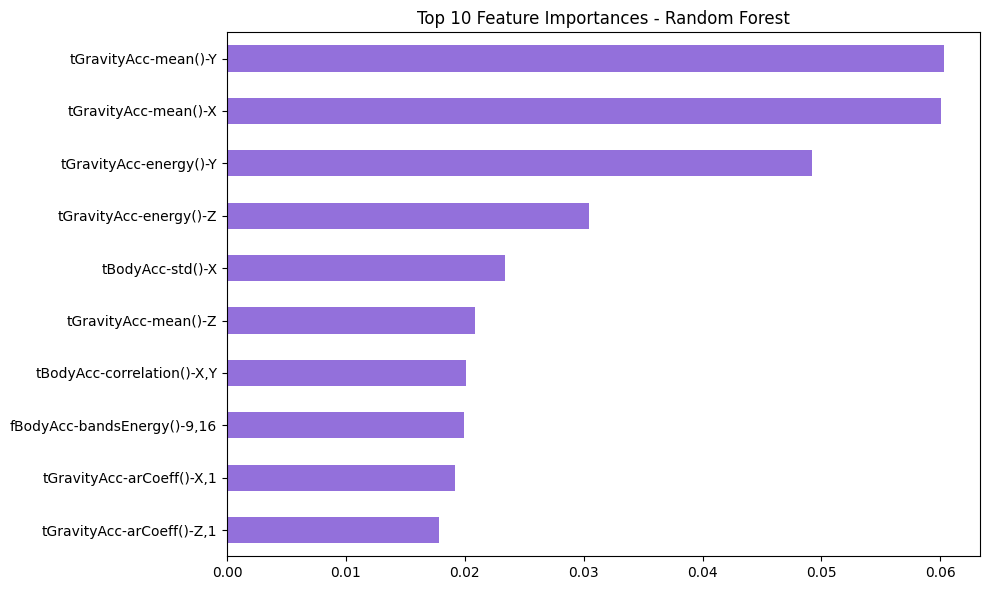


Random Sample Predictions (Random Forest):
Sample 1 (Index 1410):
  True Activity     : 1
  Predicted Activity: 1
----------------------------------------
Sample 2 (Index 6712):
  True Activity     : 6
  Predicted Activity: 6
----------------------------------------
Sample 3 (Index 2075):
  True Activity     : 5
  Predicted Activity: 5
----------------------------------------


In [7]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Random Forest: LOSO-CV Evaluation
# ----------------------------

# Extract features and labels for modeling
X_full = prepared_df.drop(columns=["Subject", "Activity", "ActivityName"])
y_full = prepared_df["Activity"]
groups = prepared_df["Subject"]

# Initialize LOSO cross-validator
logo = LeaveOneGroupOut()

# Containers for storing metrics per fold
rf_fold_accuracies = []
rf_fold_losses = []
rf_fold_reports = []
rf_fold_subjects = []  # Records which subject (group) is held out

print("Starting LOSO-CV for Random Forest:\n")

# Loop through each subject (each fold)
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    # Get the subject ID being held out for this fold
    test_subject = groups.iloc[test_idx].unique()[0]
    rf_fold_subjects.append(test_subject)
    
    # Split data into training and test sets for this fold
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the held-out subject's test data
    y_pred = rf_model.predict(X_test_fold)
    y_proba = rf_model.predict_proba(X_test_fold)
    
    # Calculate evaluation metrics
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    report = classification_report(y_test_fold, y_pred, output_dict=True)
    
    # Store metrics for this fold
    rf_fold_accuracies.append(acc)
    rf_fold_losses.append(ce_loss)
    rf_fold_reports.append(report)
    
    # Print out the results for this fold with an explanation
    print(f"Fold {fold+1} (Subject {test_subject}):")
    print(f"  Accuracy           = {acc:.4f} -> Indicates the percentage of correct predictions for the test subject.")
    print(f"  Cross-Entropy Loss = {ce_loss:.4f} -> Lower loss shows better-calibrated probability estimates.\n")

# Summarize the LOSO-CV results in a DataFrame
results_df_rf = pd.DataFrame({
    "Fold": list(range(1, len(rf_fold_accuracies)+1)),
    "Subject": rf_fold_subjects,
    "Accuracy": rf_fold_accuracies,
    "CrossEntropyLoss": rf_fold_losses
})

print("Overall LOSO-CV Results (Random Forest):")
display(results_df_rf)
print("\nAverage Accuracy: {:.4f}".format(np.mean(rf_fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(rf_fold_losses)))

# Plot the distribution of accuracies across folds for Random Forest
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df_rf, y="Accuracy")
plt.title("Random Forest Accuracy Distribution Across LOSO Folds")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# ----------------------------
# Random Forest: Final Model and Feature Importance
# ----------------------------

# Train a final Random Forest model on the entire dataset
final_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_rf_model.fit(X_full, y_full)

# Extract feature importances
importances = pd.Series(final_rf_model.feature_importances_, index=X_full.columns)
top_importances = importances.sort_values(ascending=False).head(10)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
top_importances.plot(kind="barh", color="mediumpurple")
plt.title("Top 10 Feature Importances - Random Forest")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

# ----------------------------
# Random Forest: Testing on 3 Random Samples
# ----------------------------

# Randomly select 3 samples to test the final model
random_indices = np.random.choice(X_full.index, size=3, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]

# Generate predictions for these samples
predicted_labels = final_rf_model.predict(test_samples)

# Convert encoded labels back to human-readable activity names using the label encoder
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)

print("\nRandom Sample Predictions (Random Forest):")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}):")
    print(f"  True Activity     : {true_activities[i]}")
    print(f"  Predicted Activity: {predicted_activities[i]}")
    print("-" * 40)


Starting Leave-One-Subject-Out CV for k-NN:

Fold 1 (Subject 1):
  Accuracy           = 0.8761 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.7372 -> Lower loss indicates better-calibrated probability estimates.

Fold 2 (Subject 3):
  Accuracy           = 0.8534 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.9058 -> Lower loss indicates better-calibrated probability estimates.

Fold 3 (Subject 5):
  Accuracy           = 0.8576 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 1.1460 -> Lower loss indicates better-calibrated probability estimates.

Fold 4 (Subject 6):
  Accuracy           = 0.7754 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 1.9117 -> Lower loss indicates better-calibrated probability estimates.

Fold 5 (Subject 7):
  Accuracy           = 0.8506 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 1.2211 -> Lower loss in

,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.876081,0.737151
1,2,3,0.853372,0.905803
2,3,5,0.857616,1.145982
3,4,6,0.775385,1.911699
4,5,7,0.850649,1.221076
5,6,8,0.900356,0.736285
6,7,11,0.870253,0.370133
7,8,14,0.783282,2.648687
8,9,15,0.847561,0.953031
9,10,16,0.688525,2.612264



Average Accuracy: 0.8441
Average Cross-Entropy Loss: 1.2456


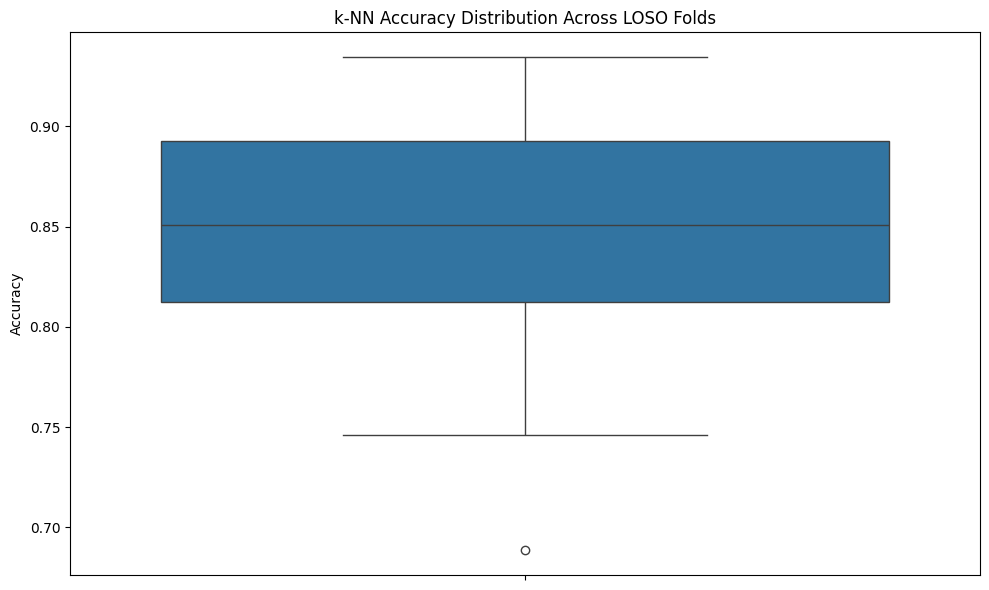


Random Sample Predictions (k-NN):
Sample 1 (Index 886):
  True Activity     : 4
  Predicted Activity: 4
----------------------------------------
Sample 2 (Index 5886):
  True Activity     : 5
  Predicted Activity: 5
----------------------------------------
Sample 3 (Index 1618):
  True Activity     : 2
  Predicted Activity: 2
----------------------------------------


In [8]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# Phase: LOSO-CV for k-Nearest Neighbors (k-NN)
# ================================

# STEP 1: Extract features, labels, and group information from prepared_df.
# prepared_df should have already been created in previous steps.
X_full = prepared_df.drop(columns=["Subject", "Activity", "ActivityName"])
y_full = prepared_df["Activity"]
groups = prepared_df["Subject"]

# STEP 2: Set up LOSO cross-validation
logo = LeaveOneGroupOut()

# Containers for storing per-fold metrics
knn_fold_accuracies = []
knn_fold_losses = []
knn_fold_reports = []
knn_fold_subjects = []  # To record which subject is left out each time

print("Starting Leave-One-Subject-Out CV for k-NN:\n")

# STEP 3: For each fold (each subject left out), train and evaluate the model.
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    # Get the subject ID for the held-out samples (all entries in test_idx have the same Subject)
    test_subject = groups.iloc[test_idx].unique()[0]
    knn_fold_subjects.append(test_subject)
    
    # Split the data into training and testing for this fold
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    # Initialize and train k-NN classifier (n_neighbors=5)
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the held-out subject's data
    y_pred = knn_model.predict(X_test_fold)
    y_proba = knn_model.predict_proba(X_test_fold)  # For computing log loss
    
    # Calculate metrics: accuracy and cross-entropy loss (log_loss)
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    report = classification_report(y_test_fold, y_pred, output_dict=True)
    
    knn_fold_accuracies.append(acc)
    knn_fold_losses.append(ce_loss)
    knn_fold_reports.append(report)
    
    # Print the results for the fold with explanations
    print(f"Fold {fold+1} (Subject {test_subject}):")
    print(f"  Accuracy           = {acc:.4f} -> Percentage of correct predictions for this subject.")
    print(f"  Cross-Entropy Loss = {ce_loss:.4f} -> Lower loss indicates better-calibrated probability estimates.\n")

# STEP 4: Summarize LOSO results in a DataFrame for k-NN
results_df_knn = pd.DataFrame({
    "Fold": list(range(1, len(knn_fold_accuracies) + 1)),
    "Subject": knn_fold_subjects,
    "Accuracy": knn_fold_accuracies,
    "CrossEntropyLoss": knn_fold_losses
})
print("Overall LOSO-CV Results (k-NN):")
display(results_df_knn)
print("\nAverage Accuracy: {:.4f}".format(np.mean(knn_fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(knn_fold_losses)))

# Visualize the distribution of accuracies across folds
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df_knn, y="Accuracy")
plt.title("k-NN Accuracy Distribution Across LOSO Folds")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# ================================
# Phase: Final k-NN Model and Random Sample Testing
# ================================

# Train a final k-NN model on the entire dataset.
final_knn_model = KNeighborsClassifier(n_neighbors=5)
final_knn_model.fit(X_full, y_full)

# Randomly select 3 samples to test the final model.
random_indices = np.random.choice(X_full.index, size=3, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]

# Generate predictions for these samples.
predicted_labels = final_knn_model.predict(test_samples)

# Convert numeric labels back to human-readable activity names using label_encoder.
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)

print("\nRandom Sample Predictions (k-NN):")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}):")
    print(f"  True Activity     : {true_activities[i]}")
    print(f"  Predicted Activity: {predicted_activities[i]}")
    print("-" * 40)

Starting LOSO-CV for SVM:

Fold 1 (Subject 1):
  Accuracy           = 0.9914 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0367 -> Lower loss indicates better-calibrated probability estimates.

Fold 2 (Subject 3):
  Accuracy           = 0.9765 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0723 -> Lower loss indicates better-calibrated probability estimates.

Fold 3 (Subject 5):
  Accuracy           = 0.8841 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.3062 -> Lower loss indicates better-calibrated probability estimates.

Fold 4 (Subject 6):
  Accuracy           = 0.8800 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.4829 -> Lower loss indicates better-calibrated probability estimates.

Fold 5 (Subject 7):
  Accuracy           = 0.9188 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.2131 -> Lower loss indicates better-cal

/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 8 (Subject 14):
  Accuracy           = 0.7368 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 1.7585 -> Lower loss indicates better-calibrated probability estimates.

Fold 9 (Subject 15):
  Accuracy           = 0.9787 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0505 -> Lower loss indicates better-calibrated probability estimates.

Fold 10 (Subject 16):
  Accuracy           = 0.8743 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.5022 -> Lower loss indicates better-calibrated probability estimates.

Fold 11 (Subject 17):
  Accuracy           = 0.9565 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0963 -> Lower loss indicates better-calibrated probability estimates.

Fold 12 (Subject 19):
  Accuracy           = 0.8833 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.2507 -> Lower loss indicates better-calibrated probability

,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.991354,0.036675
1,2,3,0.976540,0.072255
2,3,5,0.884106,0.306217
3,4,6,0.880000,0.482893
4,5,7,0.918831,0.213078
5,6,8,0.946619,0.142083
6,7,11,0.987342,0.060539
7,8,14,0.736842,1.758490
8,9,15,0.978659,0.050466
9,10,16,0.874317,0.502152



Average Accuracy: 0.9307
Average Cross-Entropy Loss: 0.2510


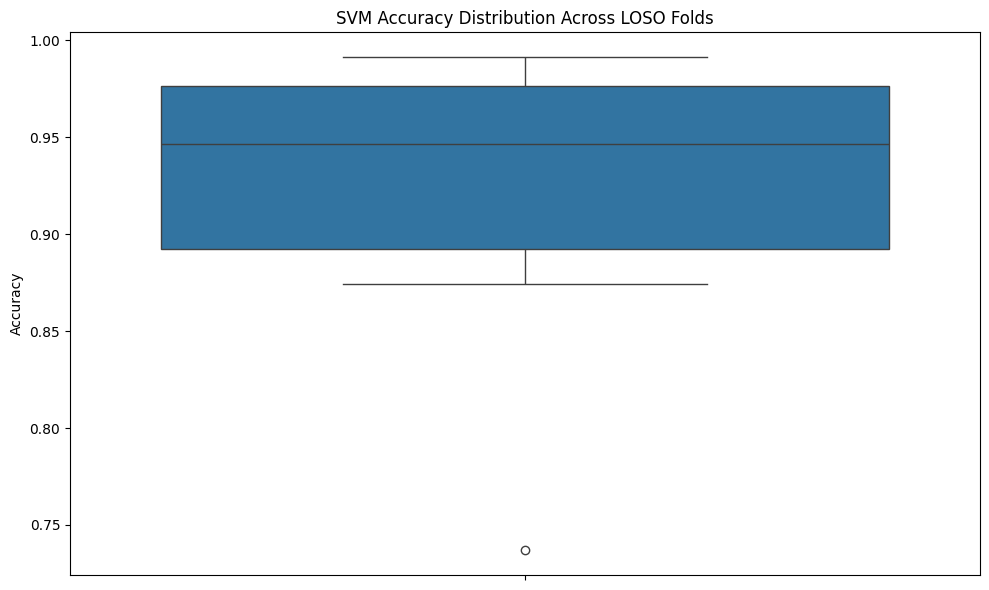


Random Sample Predictions (SVM):
Sample 1 (Index 6878):
  True Activity     : 6
  Predicted Activity: 6
----------------------------------------
Sample 2 (Index 638):
  True Activity     : 3
  Predicted Activity: 3
----------------------------------------
Sample 3 (Index 4427):
  True Activity     : 4
  Predicted Activity: 4
----------------------------------------


In [9]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# SVM: LOSO-CV Training & Evaluation
# ================================

# STEP 1: Extract features and labels from prepared_df
X_full = prepared_df.drop(columns=["Subject", "Activity", "ActivityName"])
y_full = prepared_df["Activity"]
groups = prepared_df["Subject"]

# STEP 2: Set up LOSO cross-validator (one subject left out at a time)
logo = LeaveOneGroupOut()

# Containers to store metrics for each fold
svm_fold_accuracies = []
svm_fold_losses = []
svm_fold_reports = []
svm_fold_subjects = []  # To record each held-out subject's ID

print("Starting LOSO-CV for SVM:\n")

# STEP 3: Perform LOSO-CV using SVM
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    # Get the current held-out subject
    test_subject = groups.iloc[test_idx].unique()[0]
    svm_fold_subjects.append(test_subject)
    
    # Split data for this fold
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    # Initialize and train the SVM classifier with probability estimates enabled
    svm_model = SVC(kernel='rbf', probability=True, random_state=42)
    svm_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the held-out subject's test data
    y_pred = svm_model.predict(X_test_fold)
    y_proba = svm_model.predict_proba(X_test_fold)
    
    # Calculate evaluation metrics for this fold
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    report = classification_report(y_test_fold, y_pred, output_dict=True)
    
    svm_fold_accuracies.append(acc)
    svm_fold_losses.append(ce_loss)
    svm_fold_reports.append(report)
    
    # Print results for the current fold
    print(f"Fold {fold+1} (Subject {test_subject}):")
    print(f"  Accuracy           = {acc:.4f} -> Percentage of correct predictions for this subject.")
    print(f"  Cross-Entropy Loss = {ce_loss:.4f} -> Lower loss indicates better-calibrated probability estimates.\n")

# STEP 4: Aggregate LOSO-CV results
results_df_svm = pd.DataFrame({
    "Fold": list(range(1, len(svm_fold_accuracies)+1)),
    "Subject": svm_fold_subjects,
    "Accuracy": svm_fold_accuracies,
    "CrossEntropyLoss": svm_fold_losses
})

print("Overall LOSO-CV Results (SVM):")
display(results_df_svm)
print("\nAverage Accuracy: {:.4f}".format(np.mean(svm_fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(svm_fold_losses)))

# Visualize the distribution of accuracies across folds for SVM
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df_svm, y="Accuracy")
plt.title("SVM Accuracy Distribution Across LOSO Folds")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# ================================
# SVM: Final Model and Random Sample Testing
# ================================
# Train a final SVM model on the entire dataset
final_svm_model = SVC(kernel='rbf', probability=True, random_state=42)
final_svm_model.fit(X_full, y_full)

# Randomly select 3 samples from the dataset for additional testing
random_indices = np.random.choice(X_full.index, size=3, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]

# Generate predictions for these samples
predicted_labels = final_svm_model.predict(test_samples)

# Convert numeric labels back to human-readable activity names using label_encoder
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)

print("\nRandom Sample Predictions (SVM):")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}):")
    print(f"  True Activity     : {true_activities[i]}")
    print(f"  Predicted Activity: {predicted_activities[i]}")
    print("-" * 40)


Starting LOSO-CV for XGBoost:



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 (Subject 1):
  Accuracy           = 0.9856 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0370 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 (Subject 3):
  Accuracy           = 0.9795 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0412 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 (Subject 5):
  Accuracy           = 0.8344 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.5870 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 4 (Subject 6):
  Accuracy           = 0.8615 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.4672 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 5 (Subject 7):
  Accuracy           = 0.9091 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.2699 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 6 (Subject 8):
  Accuracy           = 0.9359 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.2253 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 7 (Subject 11):
  Accuracy           = 0.9905 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0300 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 8 (Subject 14):
  Accuracy           = 0.7926 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 1.1981 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 9 (Subject 15):
  Accuracy           = 1.0000 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0178 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 10 (Subject 16):
  Accuracy           = 0.7568 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 1.3769 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 11 (Subject 17):
  Accuracy           = 0.9565 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.1183 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 12 (Subject 19):
  Accuracy           = 0.9556 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.1262 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 13 (Subject 21):
  Accuracy           = 0.8676 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.2602 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 14 (Subject 22):
  Accuracy           = 0.9875 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0392 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 15 (Subject 23):
  Accuracy           = 0.9731 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0663 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 16 (Subject 25):
  Accuracy           = 0.8533 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.4812 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 17 (Subject 26):
  Accuracy           = 0.9974 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0116 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 18 (Subject 27):
  Accuracy           = 0.9973 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0057 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 19 (Subject 28):
  Accuracy           = 0.8953 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.6358 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 20 (Subject 29):
  Accuracy           = 0.9535 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0919 -> Lower loss indicates better probability estimates.



/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 21 (Subject 30):
  Accuracy           = 0.9817 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0354 -> Lower loss indicates better probability estimates.

Overall LOSO-CV Results (XGBoost):


,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.985591,0.037002
1,2,3,0.979472,0.041242
2,3,5,0.834437,0.586966
3,4,6,0.861538,0.467219
4,5,7,0.909091,0.269898
5,6,8,0.935943,0.225316
6,7,11,0.990506,0.029958
7,8,14,0.792570,1.198116
8,9,15,1.000000,0.017789
9,10,16,0.756831,1.376935



Average Accuracy: 0.9269
Average Cross-Entropy Loss: 0.2915


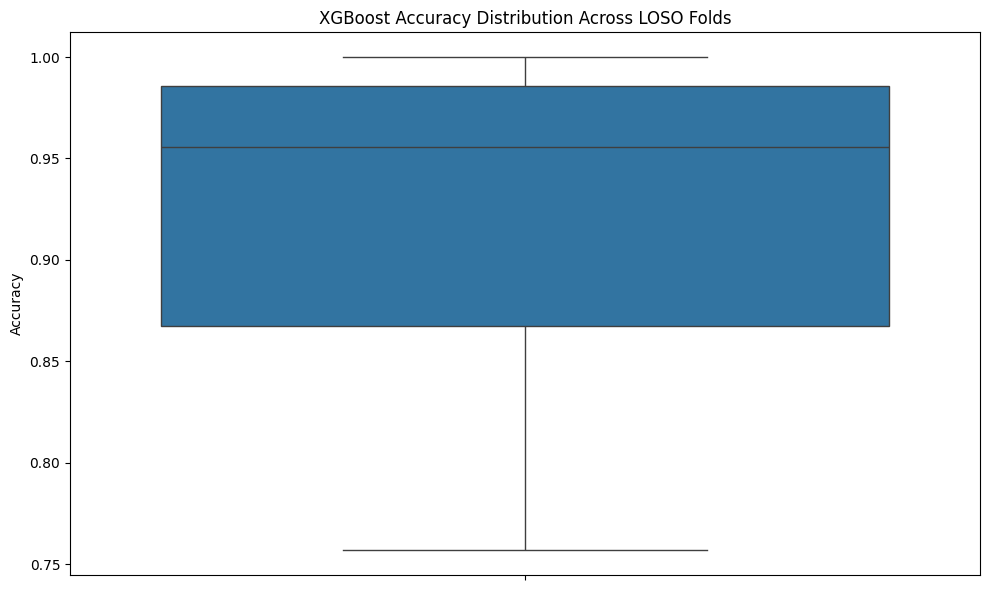

/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:46:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


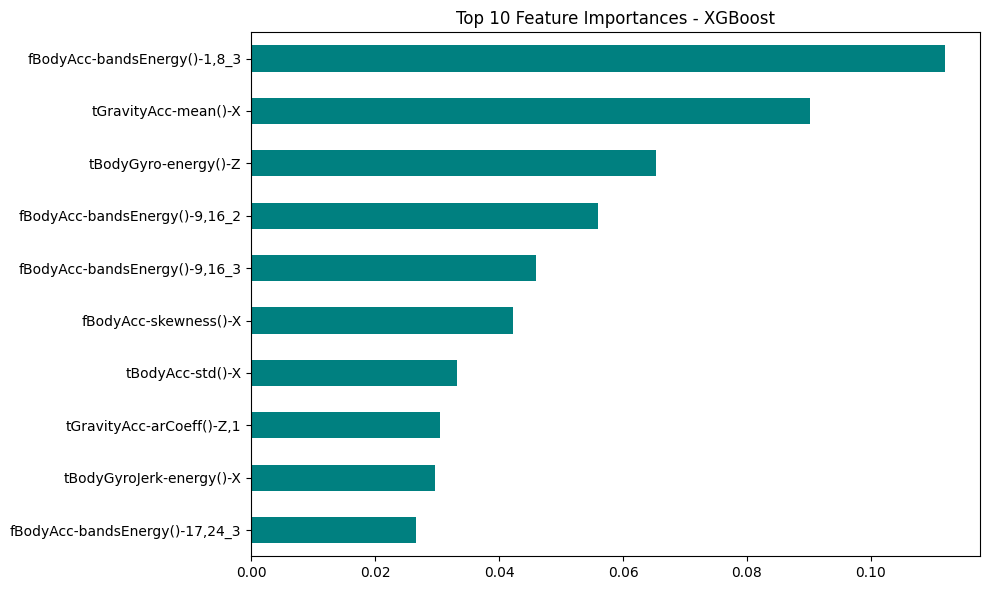


Random Sample Predictions (XGBoost):
Sample 1 (Index 2283):
  True Activity     : 6
  Predicted Activity: 6
----------------------------------------
Sample 2 (Index 2922):
  True Activity     : 4
  Predicted Activity: 4
----------------------------------------
Sample 3 (Index 3601):
  True Activity     : 3
  Predicted Activity: 3
----------------------------------------


In [10]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, log_loss, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# ==============================================
# XGBoost: LOSO-CV Training & Evaluation
# ==============================================

# STEP 1: Extract features, labels, and groups from prepared_df
X_full = prepared_df.drop(columns=["Subject", "Activity", "ActivityName"])
y_full = prepared_df["Activity"]
groups = prepared_df["Subject"]

# STEP 2: Initialize the Leave-One-Group-Out cross-validator
logo = LeaveOneGroupOut()

# Containers for storing metrics per fold
xgb_fold_accuracies = []
xgb_fold_losses = []
xgb_fold_reports = []
xgb_fold_subjects = []  # Record which subject was held out

print("Starting LOSO-CV for XGBoost:\n")

# STEP 3: Iterate over each fold (each subject)
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    # Get the current held-out subject (all test_idx rows share the same Subject)
    test_subject = groups.iloc[test_idx].unique()[0]
    xgb_fold_subjects.append(test_subject)
    
    # Split the data for this fold
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    # Initialize XGBoost classifier for multi-class classification
    xgb_model = XGBClassifier(
        objective='multi:softprob',  # multi-class probability outputs
        num_class=len(np.unique(y_full)),
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    xgb_model.fit(X_train_fold, y_train_fold)
    
    # Predictions
    y_pred = xgb_model.predict(X_test_fold)
    y_proba = xgb_model.predict_proba(X_test_fold)
    
    # Evaluate metrics
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    report = classification_report(y_test_fold, y_pred, output_dict=True)
    
    xgb_fold_accuracies.append(acc)
    xgb_fold_losses.append(ce_loss)
    xgb_fold_reports.append(report)
    
    # Print per-fold results
    print(f"Fold {fold+1} (Subject {test_subject}):")
    print(f"  Accuracy           = {acc:.4f} -> Percentage of correct predictions for this subject.")
    print(f"  Cross-Entropy Loss = {ce_loss:.4f} -> Lower loss indicates better probability estimates.\n")

# STEP 4: Summarize LOSO-CV results in a DataFrame
results_df_xgb = pd.DataFrame({
    "Fold": list(range(1, len(xgb_fold_accuracies) + 1)),
    "Subject": xgb_fold_subjects,
    "Accuracy": xgb_fold_accuracies,
    "CrossEntropyLoss": xgb_fold_losses
})

print("Overall LOSO-CV Results (XGBoost):")
display(results_df_xgb)
print("\nAverage Accuracy: {:.4f}".format(np.mean(xgb_fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(xgb_fold_losses)))

# Plot accuracy distribution across folds
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df_xgb, y="Accuracy")
plt.title("XGBoost Accuracy Distribution Across LOSO Folds")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# ==============================================
# XGBoost: Final Model, Feature Importance & Random Sample Testing
# ==============================================

# Train a final XGBoost model on the entire dataset
final_xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_full)),
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
final_xgb_model.fit(X_full, y_full)

# Extract and plot feature importances
importances = pd.Series(final_xgb_model.feature_importances_, index=X_full.columns)
top_importances = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_importances.plot(kind="barh", color="teal")
plt.title("Top 10 Feature Importances - XGBoost")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Random Sample Testing: Select 3 random samples from the dataset
random_indices = np.random.choice(X_full.index, size=3, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]

# Generate predictions for these samples
predicted_labels = final_xgb_model.predict(test_samples)

# Convert numeric labels back to human-readable activity names using label_encoder
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)

print("\nRandom Sample Predictions (XGBoost):")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}):")
    print(f"  True Activity     : {true_activities[i]}")
    print(f"  Predicted Activity: {predicted_activities[i]}")
    print("-" * 40)


Starting LOSO-CV for MLPClassifier (Neural Network):

Fold 1 (Subject 1):
  Accuracy           = 0.9914 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0213 -> Lower loss indicates more reliable probability estimates.

Fold 2 (Subject 3):
  Accuracy           = 0.9795 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0751 -> Lower loss indicates more reliable probability estimates.

Fold 3 (Subject 5):
  Accuracy           = 0.9040 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.5812 -> Lower loss indicates more reliable probability estimates.

Fold 4 (Subject 6):
  Accuracy           = 0.8769 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.8404 -> Lower loss indicates more reliable probability estimates.

Fold 5 (Subject 7):
  Accuracy           = 0.8994 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.5043 -> Lower loss indicates

/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 8 (Subject 14):
  Accuracy           = 0.7368 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 2.1573 -> Lower loss indicates more reliable probability estimates.

Fold 9 (Subject 15):
  Accuracy           = 0.9817 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.0678 -> Lower loss indicates more reliable probability estimates.

Fold 10 (Subject 16):
  Accuracy           = 0.8388 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.8579 -> Lower loss indicates more reliable probability estimates.

Fold 11 (Subject 17):
  Accuracy           = 0.9511 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.1503 -> Lower loss indicates more reliable probability estimates.

Fold 12 (Subject 19):
  Accuracy           = 0.9278 -> Percentage of correct predictions for this subject.
  Cross-Entropy Loss = 0.2466 -> Lower loss indicates more reliable probability estimates.

Fold 13

,Fold,Subject,Accuracy,CrossEntropyLoss
0,1,1,0.991354,0.021279
1,2,3,0.979472,0.075052
2,3,5,0.903974,0.581152
3,4,6,0.876923,0.840350
4,5,7,0.899351,0.504254
5,6,8,0.957295,0.089944
6,7,11,0.990506,0.022496
7,8,14,0.736842,2.157335
8,9,15,0.981707,0.067777
9,10,16,0.838798,0.857923



Average Accuracy: 0.9340
Average Cross-Entropy Loss: 0.3370


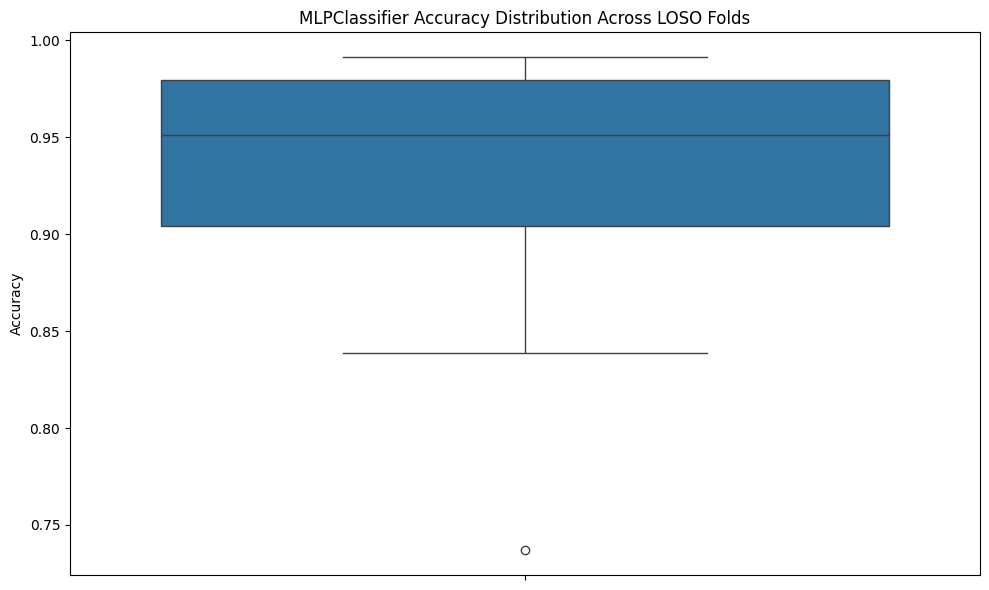


Random Sample Predictions (MLPClassifier):
Sample 1 (Index 4732):
  True Activity     : 4
  Predicted Activity: 4
----------------------------------------
Sample 2 (Index 6911):
  True Activity     : 1
  Predicted Activity: 1
----------------------------------------
Sample 3 (Index 3704):
  True Activity     : 6
  Predicted Activity: 6
----------------------------------------


In [11]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================
# MLPClassifier: LOSO-CV Training & Evaluation
# ==============================================

# STEP 1: Extract features, labels, and group info from prepared_df.
X_full = prepared_df.drop(columns=["Subject", "Activity", "ActivityName"])
y_full = prepared_df["Activity"]
groups = prepared_df["Subject"]

# STEP 2: Set up Leave-One-Group-Out CV (one subject left out per fold)
logo = LeaveOneGroupOut()

# Containers for storing metrics per fold
mlp_fold_accuracies = []
mlp_fold_losses = []
mlp_fold_reports = []
mlp_fold_subjects = []  # To record which subject is held out

print("Starting LOSO-CV for MLPClassifier (Neural Network):\n")

# STEP 3: For each fold, train MLPClassifier and evaluate.
for fold, (train_idx, test_idx) in enumerate(logo.split(X_full, y_full, groups)):
    test_subject = groups.iloc[test_idx].unique()[0]
    mlp_fold_subjects.append(test_subject)
    
    # Split data for this fold
    X_train_fold = X_full.iloc[train_idx]
    X_test_fold  = X_full.iloc[test_idx]
    y_train_fold = y_full.iloc[train_idx]
    y_test_fold  = y_full.iloc[test_idx]
    
    # Initialize and train MLPClassifier.
    # Using one hidden layer with 100 neurons, ReLU activation, and adam solver.
    mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu',
                              solver='adam', max_iter=300, random_state=42)
    mlp_model.fit(X_train_fold, y_train_fold)
    
    # Predictions for the held-out subject
    y_pred = mlp_model.predict(X_test_fold)
    y_proba = mlp_model.predict_proba(X_test_fold)
    
    # Calculate metrics: accuracy and cross-entropy loss
    acc = accuracy_score(y_test_fold, y_pred)
    ce_loss = log_loss(y_test_fold, y_proba)
    report = classification_report(y_test_fold, y_pred, output_dict=True)
    
    mlp_fold_accuracies.append(acc)
    mlp_fold_losses.append(ce_loss)
    mlp_fold_reports.append(report)
    
    # Print per-fold results
    print(f"Fold {fold+1} (Subject {test_subject}):")
    print(f"  Accuracy           = {acc:.4f} -> Percentage of correct predictions for this subject.")
    print(f"  Cross-Entropy Loss = {ce_loss:.4f} -> Lower loss indicates more reliable probability estimates.\n")

# STEP 4: Summarize LOSO-CV results in a DataFrame for MLPClassifier
results_df_mlp = pd.DataFrame({
    "Fold": list(range(1, len(mlp_fold_accuracies)+1)),
    "Subject": mlp_fold_subjects,
    "Accuracy": mlp_fold_accuracies,
    "CrossEntropyLoss": mlp_fold_losses
})

print("Overall LOSO-CV Results (MLPClassifier):")
display(results_df_mlp)
print("\nAverage Accuracy: {:.4f}".format(np.mean(mlp_fold_accuracies)))
print("Average Cross-Entropy Loss: {:.4f}".format(np.mean(mlp_fold_losses)))

# Visualize accuracy distribution across folds for MLP
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df_mlp, y="Accuracy")
plt.title("MLPClassifier Accuracy Distribution Across LOSO Folds")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# ==============================================
# MLPClassifier: Final Model and Random Sample Testing
# ==============================================
# Train a final MLPClassifier on the entire dataset.
final_mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu',
                                solver='adam', max_iter=300, random_state=42)
final_mlp_model.fit(X_full, y_full)

# Randomly select 3 samples to test the final model.
random_indices = np.random.choice(X_full.index, size=3, replace=False)
test_samples = X_full.iloc[random_indices]
true_labels = y_full.iloc[random_indices]

# Generate predictions for these samples.
predicted_labels = final_mlp_model.predict(test_samples)

# Convert numeric labels back to human-readable activity names using label_encoder.
predicted_activities = label_encoder.inverse_transform(predicted_labels)
true_activities = label_encoder.inverse_transform(true_labels)

print("\nRandom Sample Predictions (MLPClassifier):")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}):")
    print(f"  True Activity     : {true_activities[i]}")
    print(f"  Predicted Activity: {predicted_activities[i]}")
    print("-" * 40)


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:49:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


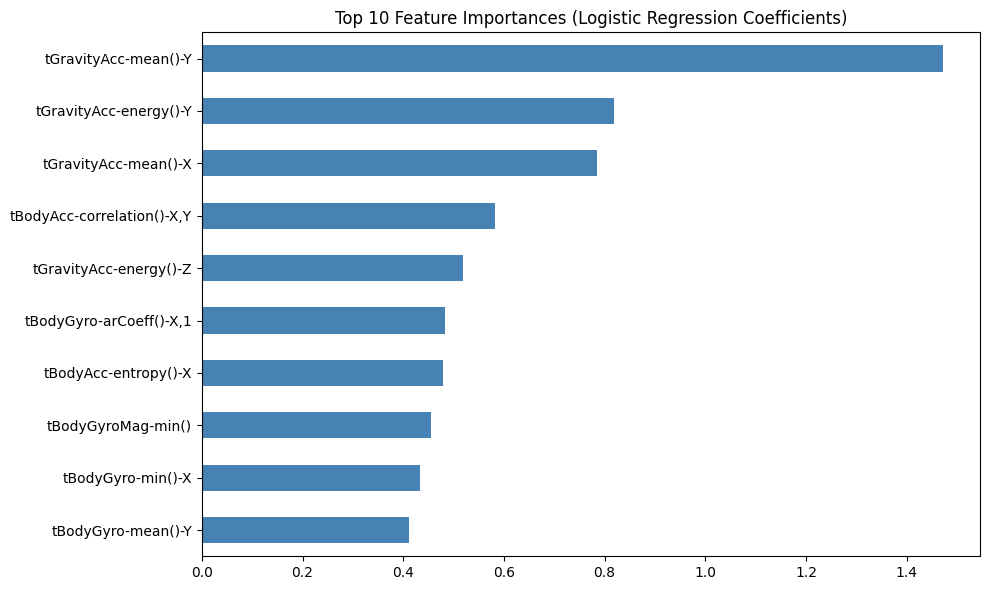

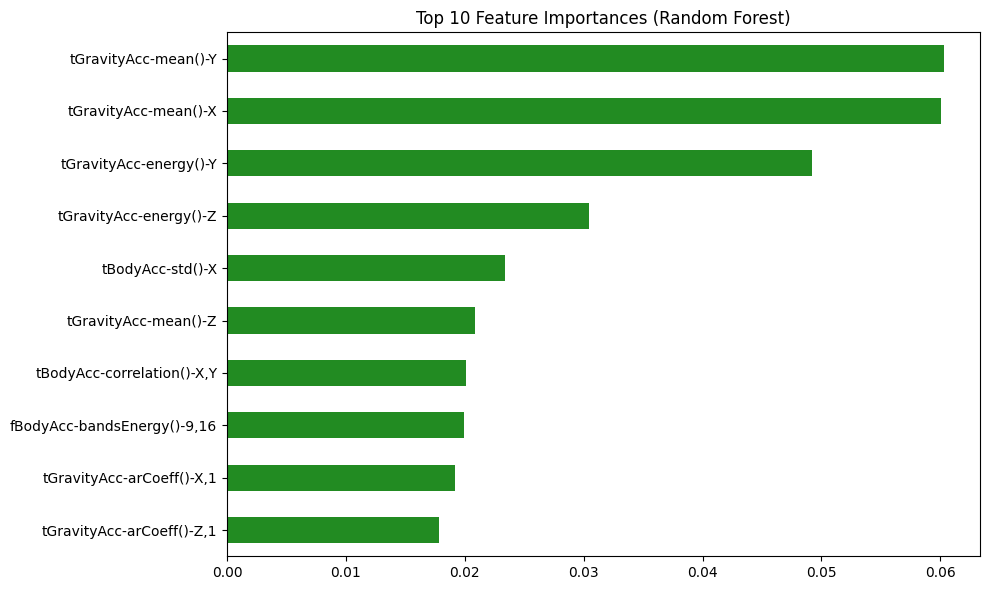

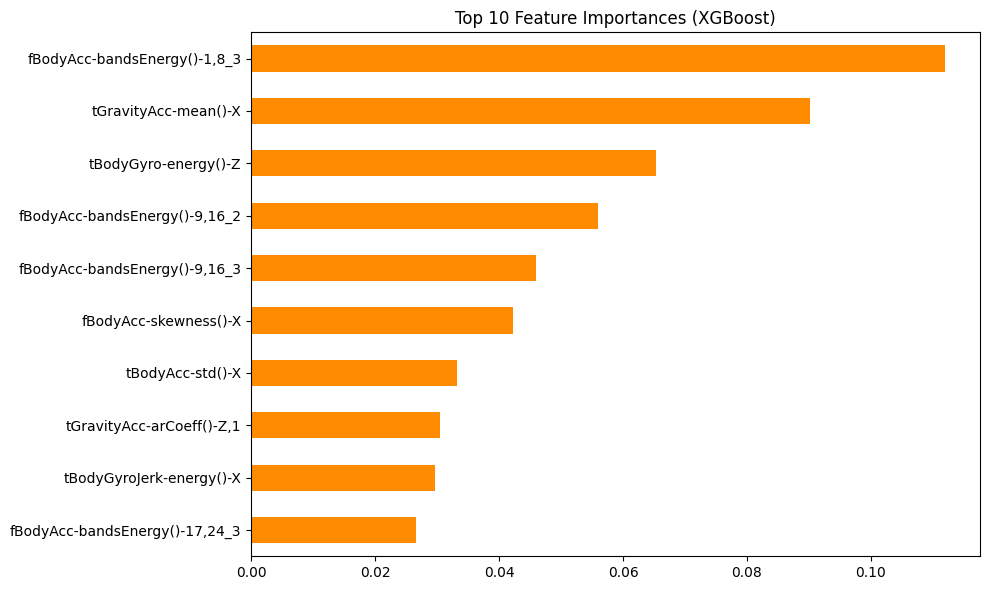

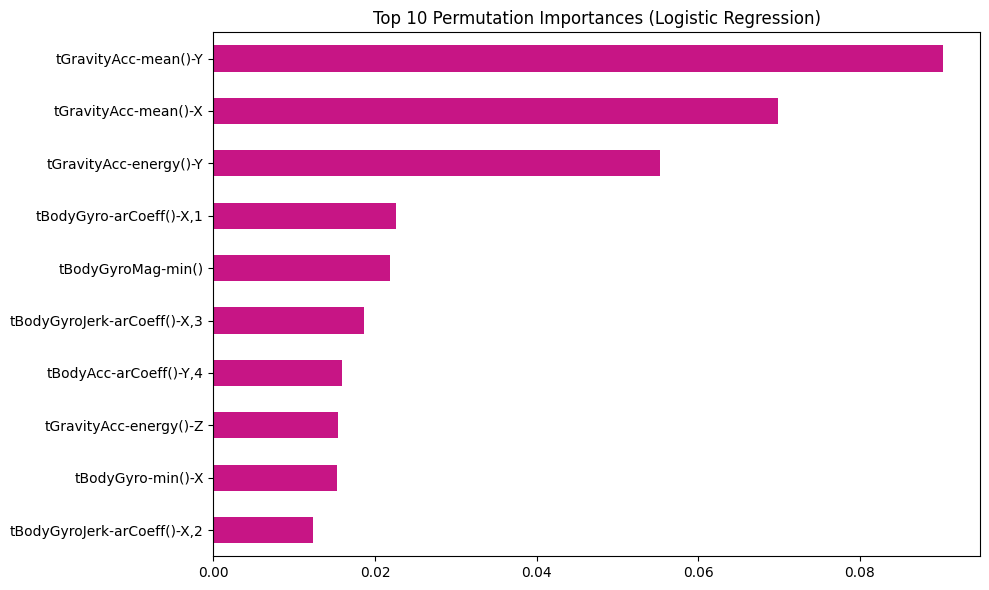

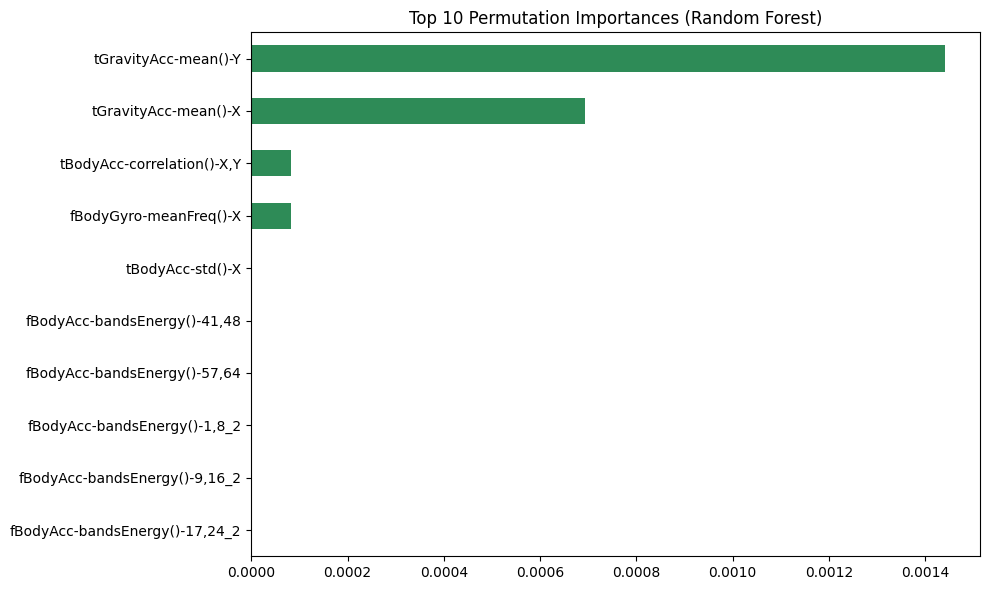

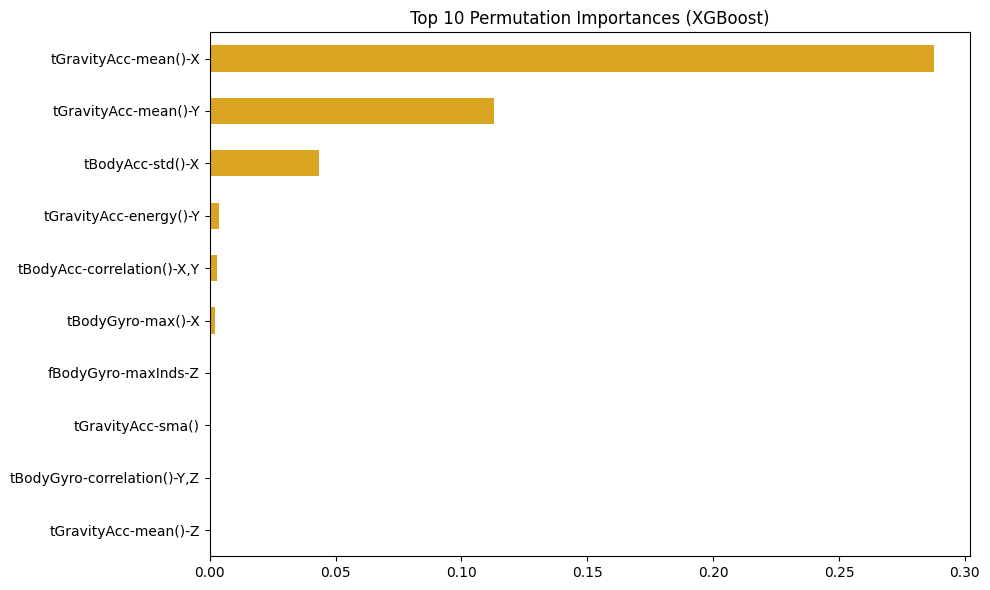

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

# -----------------------------------------------
# Step 1: Prepare the Full Data for Modeling
# -----------------------------------------------
# X_full: All feature columns
# y_full: Encoded target variable (activity)
X_full = prepared_df.drop(columns=["Subject", "Activity", "ActivityName"])
y_full = prepared_df["Activity"]

# -----------------------------------------------
# Step 2: Train Final Models on Entire Dataset
# -----------------------------------------------

# Logistic Regression (Linear Model)
final_lr_model = LogisticRegression(max_iter=300, multi_class='multinomial', solver='lbfgs', random_state=42)
final_lr_model.fit(X_full, y_full)

# Random Forest Classifier (Tree-Based Model)
final_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_rf_model.fit(X_full, y_full)

# XGBoost Classifier (Tree-Based Model)
final_xgb_model = XGBClassifier(objective='multi:softprob',
                                num_class=len(np.unique(y_full)),
                                n_estimators=100,
                                use_label_encoder=False,
                                eval_metric='mlogloss',
                                random_state=42)
final_xgb_model.fit(X_full, y_full)

# -----------------------------------------------
# Step 3: Extract Inherent Feature Importances
# -----------------------------------------------

# 3a. Logistic Regression: Use mean absolute coefficient across classes
# For multi-class logistic regression, coef_ has shape (n_classes, n_features).
lr_importances = np.mean(np.abs(final_lr_model.coef_), axis=0)
lr_importance_series = pd.Series(lr_importances, index=X_full.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
lr_importance_series.head(10).plot(kind='barh', color='steelblue')
plt.title("Top 10 Feature Importances (Logistic Regression Coefficients)")
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()

# 3b. Random Forest: Use its built-in feature importances
rf_importance_series = pd.Series(final_rf_model.feature_importances_, index=X_full.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
rf_importance_series.head(10).plot(kind='barh', color='forestgreen')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 3c. XGBoost: Use its built-in feature importances
xgb_importance_series = pd.Series(final_xgb_model.feature_importances_, index=X_full.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
xgb_importance_series.head(10).plot(kind='barh', color='darkorange')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -----------------------------------------------
# Step 4: Compute Permutation Importances
# -----------------------------------------------
# Permutation importance works by shuffling feature values and measuring drop in performance.
# We compute for each model using 10 repeats.

# For Logistic Regression
perm_lr = permutation_importance(final_lr_model, X_full, y_full, n_repeats=10, random_state=42)
perm_lr_series = pd.Series(perm_lr.importances_mean, index=X_full.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
perm_lr_series.head(10).plot(kind='barh', color='mediumvioletred')
plt.title("Top 10 Permutation Importances (Logistic Regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# For Random Forest
perm_rf = permutation_importance(final_rf_model, X_full, y_full, n_repeats=10, random_state=42)
perm_rf_series = pd.Series(perm_rf.importances_mean, index=X_full.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
perm_rf_series.head(10).plot(kind='barh', color='seagreen')
plt.title("Top 10 Permutation Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# For XGBoost
perm_xgb = permutation_importance(final_xgb_model, X_full, y_full, n_repeats=10, random_state=42)
perm_xgb_series = pd.Series(perm_xgb.importances_mean, index=X_full.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
perm_xgb_series.head(10).plot(kind='barh', color='goldenrod')
plt.title("Top 10 Permutation Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Original raw signal data shape (segmented windows): (7352, 128)
Continuous signal length: 941056

Summary of Extracted Features for Different Window Sizes:


/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_1755/2770144415.py:34: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  raw_df = pd.read_csv(signal_path, delim_whitespace=True, header=None)


,n_windows,mean_of_means,mean_of_std,mean_of_energy
Window_50,18821.0,-0.000636,0.126086,1.898284
Window_128,18819.0,-0.000548,0.129058,4.863187
Window_200,18818.0,-0.000638,0.130164,7.593358


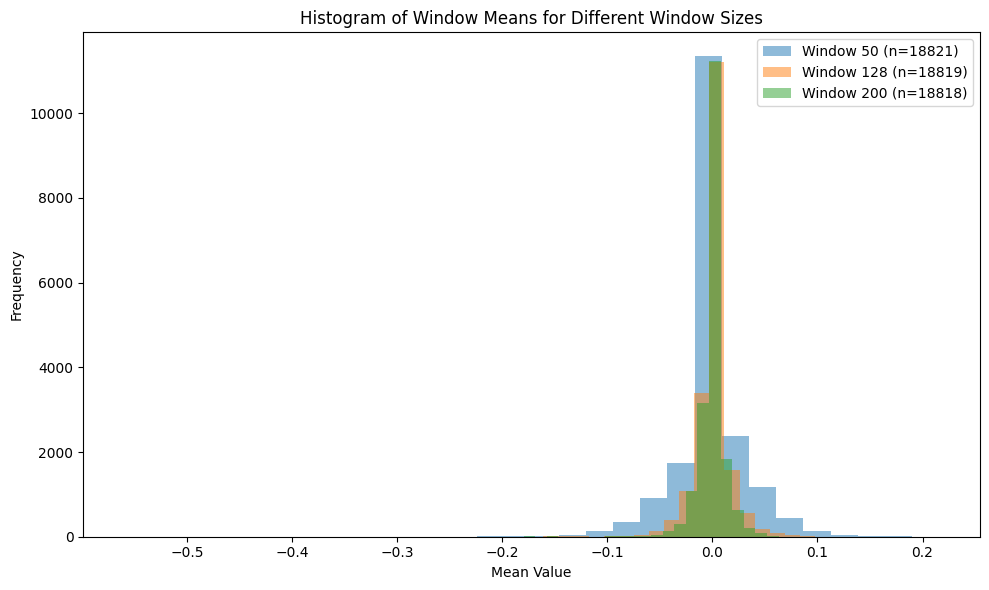

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------
# Define a function for re-segmenting a continuous signal using sliding windows.
# ------------------------------------------
def resegment_signal(signal_array, window_size, step_size):
    """
    Re-segments a 1D numpy array into multiple overlapping/non-overlapping windows.
    
    Parameters:
      signal_array (np.array): 1D array of the continuous signal.
      window_size (int): Number of samples per window.
      step_size (int): Step size between successive windows.
      
    Returns:
      windows (np.array): 2D array of shape (n_windows, window_size).
    """
    windows = []
    for i in range(0, len(signal_array) - window_size + 1, step_size):
        windows.append(signal_array[i : i + window_size])
    return np.array(windows)

# ------------------------------------------
# Load one raw inertial signal: body_acc_x_train.txt
# The file is assumed to be in "data/UCI/train/Inertial Signals/"
# Each row in the file represents the original segmented window (2.56 seconds, 128 samples)
# We will combine them to simulate a continuous signal.
# ------------------------------------------
signal_path = os.path.join("data", "UCI", "train", "Inertial Signals", "body_acc_x_train.txt")
# Read the raw file; the values are space-separated.
raw_df = pd.read_csv(signal_path, delim_whitespace=True, header=None)
print("Original raw signal data shape (segmented windows):", raw_df.shape)

# Flatten the 2D array into a 1D continuous signal.
# (Assuming the rows are in temporal order.)
continuous_signal = raw_df.values.flatten()
print("Continuous signal length:", len(continuous_signal))

# ------------------------------------------
# Define window sizes and a step size (non-overlapping windows for simplicity)
# You can experiment with overlapping windows by setting step_size < window_size.
# ------------------------------------------
window_sizes = [50, 128, 200]
step_size = 50  # change this as needed; here we use non-overlapping if window_size==50, else partial overlap for larger windows

# Function to extract simple features for a set of windows.
def extract_features(windows):
    """
    Extract mean, std, and energy (sum of squares) for each window.
    
    Parameters:
      windows (np.array): 2D array with shape (n_windows, window_size)
    
    Returns:
      features_dict (dict): Dictionary with keys 'mean', 'std', 'energy', each containing
                            an array of computed feature values.
    """
    means = np.mean(windows, axis=1)
    stds = np.std(windows, axis=1)
    energies = np.sum(windows ** 2, axis=1)
    return {"mean": means, "std": stds, "energy": energies}

# ------------------------------------------
# Segment the continuous signal using different window sizes and compute features.
# ------------------------------------------
features_summary = {}

for w_size in window_sizes:
    windows = resegment_signal(continuous_signal, window_size=w_size, step_size=step_size)
    feat = extract_features(windows)
    # Store summary statistics for each feature across windows
    summary_stats = {
        "n_windows": windows.shape[0],
        "mean_of_means": np.mean(feat["mean"]),
        "mean_of_std": np.mean(feat["std"]),
        "mean_of_energy": np.mean(feat["energy"])
    }
    features_summary[f"Window_{w_size}"] = summary_stats

# Convert features_summary to a DataFrame for easy visualization
summary_df = pd.DataFrame(features_summary).T
print("\nSummary of Extracted Features for Different Window Sizes:")
display(summary_df)

# ------------------------------------------
# Visualize the distribution of one feature (e.g., means) across different window sizes.
# ------------------------------------------
plt.figure(figsize=(10, 6))
for w_size in window_sizes:
    windows = resegment_signal(continuous_signal, window_size=w_size, step_size=step_size)
    feat = extract_features(windows)
    plt.hist(feat["mean"], bins=30, alpha=0.5, label=f'Window {w_size} (n={windows.shape[0]})')

plt.xlabel("Mean Value")
plt.ylabel("Frequency")
plt.title("Histogram of Window Means for Different Window Sizes")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import LeaveOneGroupOut

# ---------------------------------------------
# Step 1: Load Raw Inertial Signal Data
# ---------------------------------------------
# Define the folder path for the inertial signals (training set)
inertial_folder = os.path.join("data", "UCI", "train", "Inertial Signals")

# List of raw file names for the 9 channels:
channels = [
    "body_acc_x_train.txt", "body_acc_y_train.txt", "body_acc_z_train.txt",
    "body_gyro_x_train.txt", "body_gyro_y_train.txt", "body_gyro_z_train.txt",
    "total_acc_x_train.txt", "total_acc_y_train.txt", "total_acc_z_train.txt"
]

# Load each channel's data into a list (each file is a DataFrame with shape (7352, 128))
raw_data_list = []
for file in channels:
    file_path = os.path.join(inertial_folder, file)
    channel_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    raw_data_list.append(channel_data.values)  # convert to NumPy array

# Stack channels along a new axis (last dimension)
# Resulting shape: (num_samples, timesteps, channels) => (7352, 128, 9)
X_raw = np.stack(raw_data_list, axis=-1)
print("Shape of raw input data (X_raw):", X_raw.shape)

# ---------------------------------------------
# Step 2: Load Labels and Subject IDs for Raw Data
# ---------------------------------------------
# Load activity labels (train set)
y_raw_df = pd.read_csv(os.path.join("data", "UCI", "train", "y_train.txt"), header=None, names=["Activity"])
# Load subject IDs (train set)
subject_raw_df = pd.read_csv(os.path.join("data", "UCI", "train", "subject_train.txt"), header=None, names=["Subject"])

y_raw = y_raw_df["Activity"].values  # shape (7352,)
subjects = subject_raw_df["Subject"].values  # shape (7352,)

# Convert activity labels to one-hot encoding
# Assuming labels are 1-indexed, subtract 1 to get 0-indexed class labels.
num_classes = len(np.unique(y_raw))
y_cat = to_categorical(y_raw - 1, num_classes=num_classes)

print("Number of classes:", num_classes)

# ---------------------------------------------
# Step 3: Define an LSTM Model Function
# ---------------------------------------------
def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    # LSTM layer with 64 units; you can experiment with more layers or units
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_raw.shape[1], X_raw.shape[2])
print("Input shape for LSTM model:", input_shape)

# ---------------------------------------------
# Step 4: LOSO Cross-Validation for LSTM
# ---------------------------------------------
logo = LeaveOneGroupOut()
lstm_fold_accuracies = []
lstm_fold_losses = []
lstm_fold_subjects = []

print("\nStarting Leave-One-Subject-Out Cross-Validation (LOSO-CV) for LSTM:\n")
# Iterate over each subject as the test set
for fold, (train_idx, test_idx) in enumerate(logo.split(X_raw, y_raw, subjects)):
    # Get the test subject ID (all test_idx rows are from one subject)
    test_subject = subjects[test_idx][0]
    lstm_fold_subjects.append(test_subject)
    
    # Split data into training and testing for this fold
    X_train_fold, X_test_fold = X_raw[train_idx], X_raw[test_idx]
    y_train_fold, y_test_fold = y_cat[train_idx], y_cat[test_idx]
    
    # Build and train the LSTM model for this fold
    model = build_lstm_model(input_shape, num_classes)
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
    
    # Evaluate on the held-out subject
    loss, acc = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    lstm_fold_accuracies.append(acc)
    lstm_fold_losses.append(loss)
    
    print(f"Fold {fold+1} (Subject {test_subject}) - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

print("\nAverage LSTM Accuracy: {:.4f}".format(np.mean(lstm_fold_accuracies)))
print("Average LSTM Loss: {:.4f}".format(np.mean(lstm_fold_losses)))

# ---------------------------------------------
# Step 5: Final LSTM Model Training and Random Sample Testing
# ---------------------------------------------
# Train a final LSTM model on the entire raw training dataset
final_lstm_model = build_lstm_model(input_shape, num_classes)
final_lstm_model.fit(X_raw, y_cat, epochs=10, batch_size=32, verbose=1)

# Randomly select 3 samples from the raw data
random_indices = np.random.choice(X_raw.shape[0], size=3, replace=False)
test_samples = X_raw[random_indices]
true_labels = y_raw[random_indices]

# Predict using the final LSTM model
pred_probs = final_lstm_model.predict(test_samples)
# Select the class with the highest probability, then add 1 to convert back to original label scale
pred_classes = np.argmax(pred_probs, axis=1) + 1

print("\nRandom Sample Predictions (LSTM):")
for i, idx in enumerate(random_indices):
    print(f"Sample {i+1} (Index {idx}):")
    print(f"  True Activity     : {true_labels[i]}")
    print(f"  Predicted Activity: {pred_classes[i]}")
    print("-" * 40)


/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_1755/367710662.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  channel_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_1755/367710662.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  channel_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_1755/367710662.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  channel_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_1755/367710662.py:28: FutureWarning: The 'de

Shape of raw input data (X_raw): (7352, 128, 9)
Number of classes: 6
Input shape for LSTM model: (128, 9)

Starting Leave-One-Subject-Out Cross-Validation (LOSO-CV) for LSTM:

Fold 1 (Subject 1) - Accuracy: 0.9856, Loss: 0.0669
Fold 2 (Subject 3) - Accuracy: 0.9912, Loss: 0.0704
Fold 3 (Subject 5) - Accuracy: 0.8046, Loss: 0.4327
Fold 4 (Subject 6) - Accuracy: 0.9385, Loss: 0.1498
Fold 5 (Subject 7) - Accuracy: 0.7922, Loss: 0.3486
Fold 6 (Subject 8) - Accuracy: 0.9253, Loss: 0.1671
Fold 7 (Subject 11) - Accuracy: 0.8544, Loss: 0.3555
Fold 8 (Subject 14) - Accuracy: 0.6347, Loss: 1.5268
Fold 9 (Subject 15) - Accuracy: 0.9268, Loss: 0.2153
Fold 10 (Subject 16) - Accuracy: 0.6885, Loss: 1.7821
Fold 11 (Subject 17) - Accuracy: 0.9103, Loss: 0.2257
Fold 12 (Subject 19) - Accuracy: 0.9528, Loss: 0.3123
Fold 13 (Subject 21) - Accuracy: 0.8211, Loss: 0.2682
Fold 14 (Subject 22) - Accuracy: 0.9844, Loss: 0.1547
Fold 15 (Subject 23) - Accuracy: 0.9328, Loss: 0.2084
Fold 16 (Subject 25) - Accura

/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_1755/4130879258.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  channel_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_1755/4130879258.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  channel_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_1755/4130879258.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  channel_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_1755/4130879258.py:30: FutureWarning: The

Shape of raw input data (X_raw): (7352, 128, 9)
Number of classes: 6
Window 128 shape: (7352, 128, 9)
Window 50 shape: (14704, 50, 9)
Window 200 shape: (3615, 200, 9)

Training LSTM for window size 128 with input shape: (128, 9)


/opt/anaconda3/envs/aura1/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Window Size 128 -> Accuracy: 0.8899, Loss: 0.3171
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Training LSTM for window size 50 with input shape: (50, 9)
Window Size 50 -> Accuracy: 0.9262, Loss: 0.2167
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training LSTM for window size 200 with input shape: (200, 9)
Window Size 200 -> Accuracy: 0.6625, Loss: 0.7687
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Random Sample Predictions for window size 128:
Sample 1 (Test Index 728): True Activity: 1, Predicted Activity: 1
Sample 2 (Test Index 742): True Activity: 2, Predicted Activity: 2
Sample 3 (Test Index 1439): True Activity: 6, Predicted Activity: 6
Sample 4 (Test Index 1302): True Activity: 1, Predicted Activity: 1
Sample 5 (Test Index 1330): True Activity: 3, Predicted Activity: 3
Sample 6 (Test Index 891): True Activity: 3, Predicted Activity: 1
Sample 7 (Test Index 1448): True Activity: 5, Predicted Activity: 5
Sample 8 (Test Index 42): True Activity: 1, Predicted

/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_1755/4130879258.py:182: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=window_sizes, y=accuracies, palette='viridis')


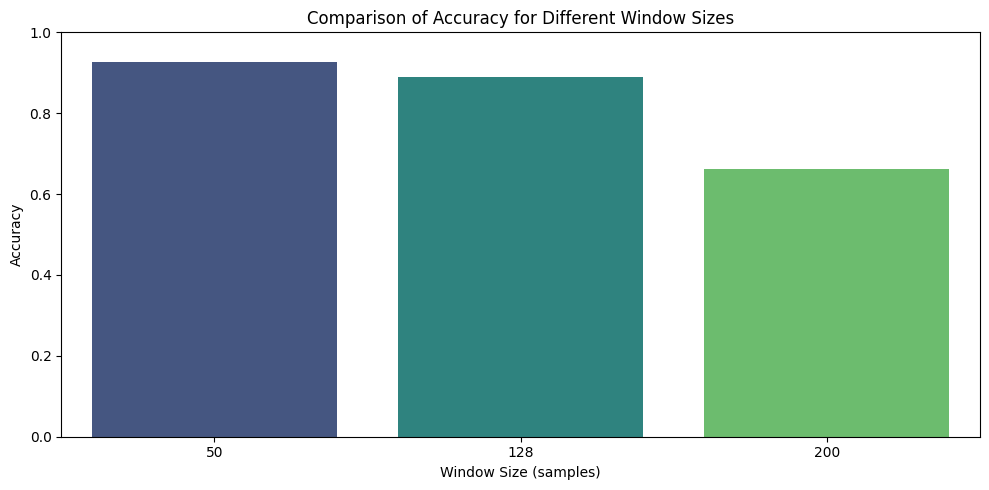

/var/folders/4b/vy5yxhcn1735bmfhxdmhpv8r0000gn/T/ipykernel_1755/4130879258.py:191: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=window_sizes, y=losses, palette='magma')


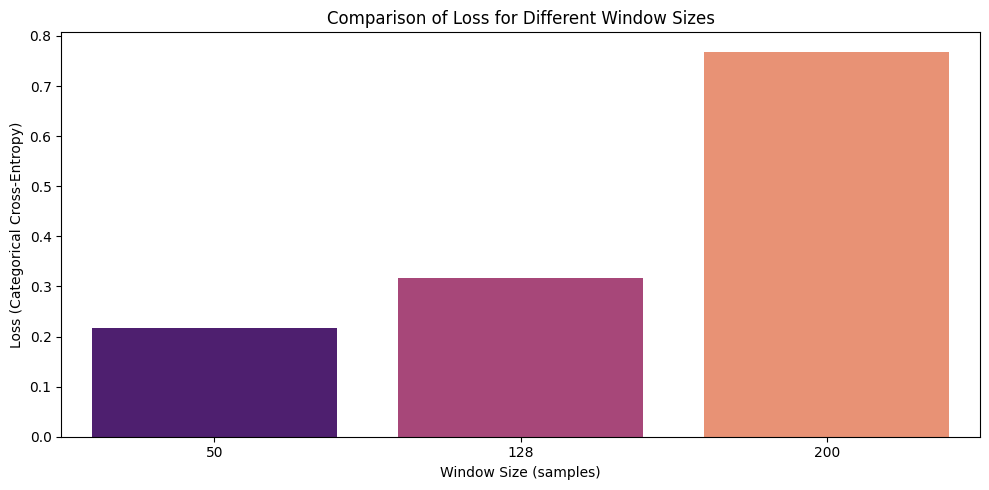

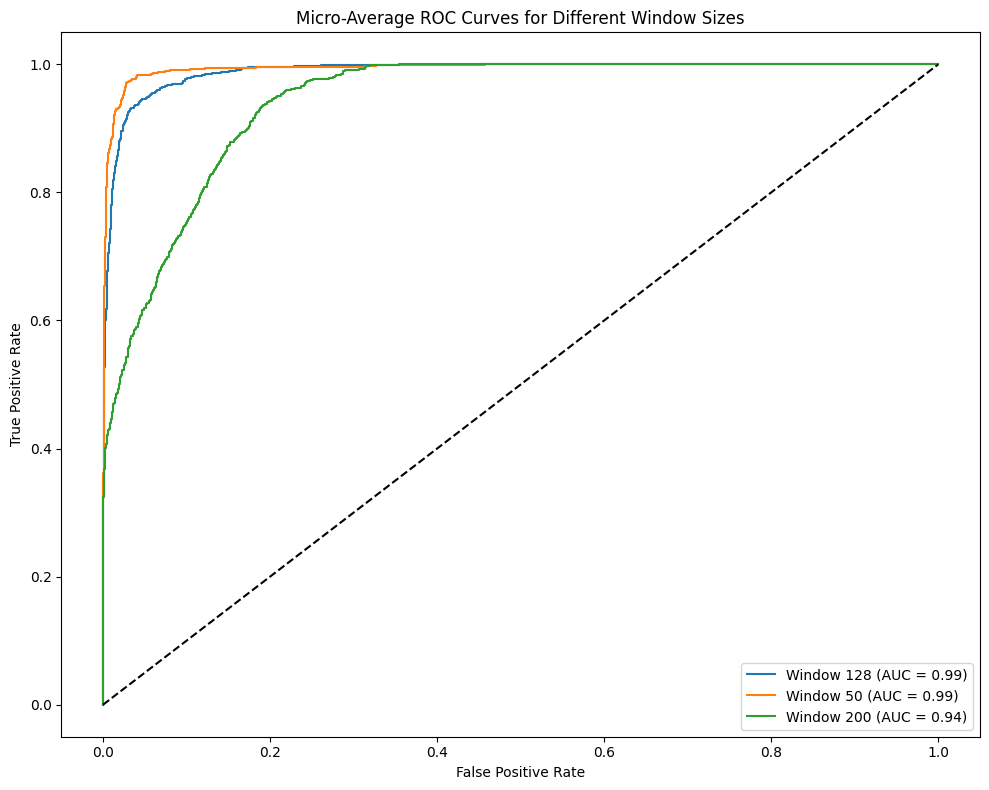

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc

# -------------------------------
# Step 0: Load Raw Inertial Data (All 9 Channels)
# -------------------------------
# Define the folder path for the inertial signals (training set)
inertial_folder = os.path.join("data", "UCI", "train", "Inertial Signals")

# List of channel file names:
channels = [
    "body_acc_x_train.txt", "body_acc_y_train.txt", "body_acc_z_train.txt",
    "body_gyro_x_train.txt", "body_gyro_y_train.txt", "body_gyro_z_train.txt",
    "total_acc_x_train.txt", "total_acc_y_train.txt", "total_acc_z_train.txt"
]

# Load each channel's data into a list of NumPy arrays (each with shape (7352, 128))
raw_data_list = []
for file in channels:
    file_path = os.path.join(inertial_folder, file)
    channel_data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    raw_data_list.append(channel_data.values)

# Stack channels along a new axis (last dimension)
# This yields X_raw with shape: (7352, 128, 9)
X_raw = np.stack(raw_data_list, axis=-1)
print("Shape of raw input data (X_raw):", X_raw.shape)

# Load corresponding activity labels and subject IDs
y_raw_df = pd.read_csv(os.path.join("data", "UCI", "train", "y_train.txt"), header=None, names=["Activity"])
subject_raw_df = pd.read_csv(os.path.join("data", "UCI", "train", "subject_train.txt"), header=None, names=["Subject"])
y_raw = y_raw_df["Activity"].values   # shape (7352,)
subjects = subject_raw_df["Subject"].values  # shape (7352,)

# Convert activity labels to one-hot encoding (assuming labels are 1-indexed)
num_classes = len(np.unique(y_raw))
y_cat_full = to_categorical(y_raw - 1, num_classes=num_classes)
print("Number of classes:", num_classes)

# -------------------------------
# Step 1: Define Windowing Functions
# -------------------------------

def resegment_50(X_raw, y_raw):
    """
    For each original 128-sample segment in X_raw, resegment into non-overlapping windows of length 50.
    For each original sample (shape: (128, 9)), we extract windows starting at index 0 and 50.
    (The remainder is dropped.)
    Returns:
      X_50: New data array of shape (n_windows, 50, 9)
      y_50: Corresponding labels (each original sample's label repeated for each window)
    """
    X_50_list = []
    y_50_list = []
    for i in range(X_raw.shape[0]):
        sample = X_raw[i]  # shape (128, 9)
        # For non-overlapping windows: indices 0 and 50 if 0+50<=128 and 50+50<=128.
        for start in [0, 50]:
            if start + 50 <= sample.shape[0]:
                window = sample[start:start+50]
                X_50_list.append(window)
                y_50_list.append(y_raw[i])
    X_50 = np.array(X_50_list)
    y_50 = np.array(y_50_list)
    return X_50, y_50

def resegment_200(X_raw, y_raw):
    """
    Combine two consecutive original windows (if they share the same label) to create a longer window.
    For each pair of consecutive samples in X_raw, if y_raw[i] == y_raw[i+1],
    concatenate them along the time axis and take the first 200 samples.
    Returns:
      X_200: New data array of shape (n_pairs, 200, 9)
      y_200: Corresponding labels (for each pair, the common label)
    """
    X_200_list = []
    y_200_list = []
    i = 0
    while i < X_raw.shape[0] - 1:
        if y_raw[i] == y_raw[i+1]:
            combined = np.concatenate([X_raw[i], X_raw[i+1]], axis=0)  # shape (256, 9)
            window = combined[:200]  # take first 200 samples
            X_200_list.append(window)
            y_200_list.append(y_raw[i])
            i += 2  # skip the next one as it's paired
        else:
            i += 1  # skip if labels do not match
    X_200 = np.array(X_200_list)
    y_200 = np.array(y_200_list)
    return X_200, y_200

# For the 128-sample model, we use the original X_raw and y_raw.
X_128 = X_raw
y_128 = y_raw

# Create re-segmented datasets for window sizes 50 and 200.
X_50, y_50 = resegment_50(X_raw, y_raw)
X_200, y_200 = resegment_200(X_raw, y_raw)

print(f"Window 128 shape: {X_128.shape}")  # Expected: (7352, 128, 9)
print(f"Window 50 shape: {X_50.shape}")     # Expected: (~7352*2, 50, 9)
print(f"Window 200 shape: {X_200.shape}")   # Expected: (n_pairs, 200, 9)

# Convert the labels to one-hot for each dataset
y_cat_128 = to_categorical(y_128 - 1, num_classes=num_classes)
y_cat_50 = to_categorical(y_50 - 1, num_classes=num_classes)
y_cat_200 = to_categorical(y_200 - 1, num_classes=num_classes)

# -------------------------------
# Step 2: Define a Function to Build LSTM Model
# -------------------------------
def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# -------------------------------
# Step 3: Split Data, Train, and Evaluate for Each Window Size
# -------------------------------
from sklearn.model_selection import train_test_split

def train_and_evaluate(X, y_cat, window_size):
    # Split data 80/20 for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)
    input_shape = (X_train.shape[1], X_train.shape[2])
    print(f"\nTraining LSTM for window size {window_size} with input shape: {input_shape}")
    
    model = build_lstm_model(input_shape, num_classes)
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Window Size {window_size} -> Accuracy: {acc:.4f}, Loss: {loss:.4f}")
    
    # Predict on test set for ROC later (we will return probabilities and true labels)
    y_proba = model.predict(X_test)
    return model, acc, loss, X_test, y_test, y_proba

# Train models for each window configuration
model_128, acc_128, loss_128, X_test_128, y_test_128, y_proba_128 = train_and_evaluate(X_128, y_cat_128, 128)
model_50,  acc_50,  loss_50,  X_test_50,  y_test_50,  y_proba_50  = train_and_evaluate(X_50,  y_cat_50,  50)
model_200, acc_200, loss_200, X_test_200, y_test_200, y_proba_200 = train_and_evaluate(X_200, y_cat_200, 200)

# -------------------------------
# Step 4: Test Each Model on 10 Random Examples from Their Test Sets
# -------------------------------
def test_random_samples(model, X_test, y_test, window_size):
    indices = np.random.choice(X_test.shape[0], size=10, replace=False)
    sample_X = X_test[indices]
    # True labels: convert from one-hot back to original numeric (add 1 for 1-indexing)
    true_labels = np.argmax(y_test[indices], axis=1) + 1
    pred_probs = model.predict(sample_X)
    pred_labels = np.argmax(pred_probs, axis=1) + 1
    
    print(f"\nRandom Sample Predictions for window size {window_size}:")
    for i, idx in enumerate(indices):
        print(f"Sample {i+1} (Test Index {idx}): True Activity: {true_labels[i]}, Predicted Activity: {pred_labels[i]}")
        
test_random_samples(model_128, X_test_128, y_test_128, 128)
test_random_samples(model_50,  X_test_50,  y_test_50, 50)
test_random_samples(model_200, X_test_200, y_test_200, 200)

# -------------------------------
# Step 5: Comparison Plots for Accuracy and Loss
# -------------------------------
window_sizes = ['50', '128', '200']
accuracies = [acc_50, acc_128, acc_200]
losses = [loss_50, loss_128, loss_200]

plt.figure(figsize=(10, 5))
sns.barplot(x=window_sizes, y=accuracies, palette='viridis')
plt.xlabel("Window Size (samples)")
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy for Different Window Sizes")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=window_sizes, y=losses, palette='magma')
plt.xlabel("Window Size (samples)")
plt.ylabel("Loss (Categorical Cross-Entropy)")
plt.title("Comparison of Loss for Different Window Sizes")
plt.tight_layout()
plt.show()

# -------------------------------
# (Optional) Step 6: Plot ROC Curves for Each Model
# -------------------------------
# For multi-class ROC, we'll compute micro-average ROC curves.
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_multiclass_roc(y_test, y_proba, window_size):
    # y_test is one-hot encoded
    fpr, tpr, _ = roc_curve(y_test.ravel(), y_proba.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Window {window_size} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 8))
plot_multiclass_roc(y_test_128, y_proba_128, 128)
plot_multiclass_roc(y_test_50,  y_proba_50, 50)
plot_multiclass_roc(y_test_200, y_proba_200, 200)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-Average ROC Curves for Different Window Sizes")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
